In [1]:
%pip install langchain unstructured[all-docs] pydantic lxml pytesseract json-repair
%pip install openai wikipedia tiktoken neo4j python-dotenv yfiles_jupyter_graphs
%pip install --upgrade --quiet  langchain langchain-community langchain-openai langchain-experimental neo4j

zsh:1: no matches found: unstructured[all-docs]
Note: you may need to restart the kernel to use updated packages.
  Using cached wikipedia-1.4.0.tar.gz (27 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached neo4j-5.27.0-py3-none-any.whl.metadata (5.9 kB)
Using cached neo4j-5.27.0-py3-none-any.whl (301 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 4.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 6.3 MB/s eta 0:00:00a 0:00:01
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11728 sha256=69447ce68641bcd30e5fe2925447db3bb8c692f8cda7eb2220447fea4d65004c
  Stored in directory: /Users/ngocp/Library/Caches/pip/wheels/63/47/7c/a9688349aa74d228ce0a9023229c6c0ac52ca2a40fe87679b8
Successfully built wikipedia
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to u

In [7]:
!pip install langchain_neo4j

In [25]:
import os
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
import uuid
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain.storage import InMemoryStore
from langchain_neo4j import Neo4jGraph, GraphCypherQAChain, Neo4jVector
from langchain_core.prompts.prompt import PromptTemplate
from dotenv import load_dotenv
from langchain_core.runnables import RunnablePassthrough
from yfiles_jupyter_graphs import GraphWidget
from neo4j import GraphDatabase
from langchain_experimental.graph_transformers import LLMGraphTransformer

load_dotenv("../.env")

True

In [15]:
import glob

text = ""
for filename in glob.glob('example_data/*.txt'):
    with open(filename, 'r') as file:
        text += file.read() + "\n"
documents = []

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_text(text)

id_key = "document_id"  # Define the id_key variable

for i, t in enumerate(texts):
    doc = Document(page_content=t, id=str(i), metadata={id_key: str(uuid.uuid4())})
    documents.append(doc)


In [34]:
llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

In [28]:
os.environ["NEO4J_URI"] = os.getenv("NEO4J_URI")
os.environ["NEO4J_USERNAME"] = os.getenv("NEO4J_USERNAME")
os.environ["NEO4J_PASSWORD"] = os.getenv("NEO4J_PASSWORD")


In [40]:
# Define the Neo4jGraph object
def truncate_database():
    uri = os.getenv("NEO4J_URI")
    username = os.getenv("NEO4J_USERNAME")
    password = os.getenv("NEO4J_PASSWORD")
    driver = GraphDatabase.driver(uri, auth=(username, password))

    # Define a function to truncate the database
    def truncate_database(driver):
        with driver.session() as session:
            session.run("MATCH (n) DETACH DELETE n")

    # Truncate the database
    truncate_database(driver)

    # Close the driver connection
    driver.close()

truncate_database()

In [ ]:
# Establish a connection to the Neo4j database

db = Neo4jVector.from_documents(
    documents, OpenAIEmbeddings()
)

In [31]:
query = "UBND TP. Hải Phòng phê duyệt điều gì ?"
docs_with_score = db.similarity_search_with_score(query, k=2)
print(docs_with_score)

[(Document(metadata={'document_id': '47f8fe94-ba05-40dd-b1d5-cdac9078002d'}, page_content='Thêm 2 dự án của Kinh Bắc City tại Hải Phòng được cấp chứng nhận đăng ký đầu tư với tổng vốn hơn 77.000 tỷ đồng- Ảnh 4.\nPhối cảnh dự án KCN Tràng Duệ 3, TP.Hải Phòng\n\nDự án KCN Tràng Duệ 3 được triển khai với mong muốn tiếp nối thành công của Khu công nghiệp Tràng Duệ 1 và 2 (huyện An Dương, TP Hải Phòng) – được đầu tư xây dựng từ năm 2007 với các hạng mục hạ tầng cơ sở đồng bộ, hiện đại; đã thu hút các dự án lớn, nhỏ cả trong và ngoài nước; đặc biệt là các dự án của Tập đoàn LG như LG Display, LG Electronics, LG Innotek, LG Chem. Đến hiện tại, KCN Tràng Duệ giai đoạn 1&2 (quy mô 401ha) đã được lấp đầy toàn bộ 100% đất thương phẩm (112 dự án) với tổng số vốn đầu tư lên tới gần 11 tỉ đô la Mỹ, cho thấy sức hấp dẫn của thành phố Hải Phòng nói chung, của KCN Tràng Duệ 1+2 nói riêng.\n\n\nThêm 2 dự án của Kinh Bắc City tại Hải Phòng được cấp chứng nhận đăng ký đầu tư với tổng vốn hơn 77.000 tỷ đồn

In [35]:
llm_transformer = LLMGraphTransformer(llm=llm)

graph_documents = llm_transformer.convert_to_graph_documents(documents)
print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

Nodes:[Node(id='Vpbank', type='Organization', properties={}), Node(id='Hdbank', type='Organization', properties={}), Node(id='Gpbank', type='Organization', properties={}), Node(id='Dongabank', type='Organization', properties={}), Node(id='Ngân Hàng Nhà Nước Việt Nam', type='Organization', properties={}), Node(id='Hà Nội', type='Location', properties={}), Node(id='17/1/2025', type='Date', properties={})]
Relationships:[Relationship(source=Node(id='Ngân Hàng Nhà Nước Việt Nam', type='Organization', properties={}), target=Node(id='Gpbank', type='Organization', properties={}), type='TRANSFER', properties={}), Relationship(source=Node(id='Ngân Hàng Nhà Nước Việt Nam', type='Organization', properties={}), target=Node(id='Dongabank', type='Organization', properties={}), type='TRANSFER', properties={}), Relationship(source=Node(id='Gpbank', type='Organization', properties={}), target=Node(id='Vpbank', type='Organization', properties={}), type='RECEIVED_BY', properties={}), Relationship(source=

In [62]:
graph = Neo4jGraph(enhanced_schema=True)
graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


In [63]:
print(graph.schema)

Node properties:
- **Person**
  - `id`: STRING Available options: ['Người Gửi Tiền', 'Khách Hàng', 'Trần Hồng Hà']
- **Document**
  - `id`: STRING Available options: ['cc4e396ee302fbdc27571d38edf0859a', 'f84b4c94dfe59a340316a3bebe0396e6', 'b9eee038b22947a42f767404209d716b', '424409a50f3e71735d3d8ff95e1519a5', 'fbae417102168efcf18a6bcc205c896c', '519d03a7ae0c8c9f8febe2c6dee287ff', '471bc25fa35287dccf5b8f95604f2835']
  - `document_id`: STRING Available options: ['96db9155-2a83-401d-a7cd-ba17e1cd509a', '57a5da93-1b35-42c2-8728-3f3fab6e63dc', 'f7ab44ba-bdb2-4338-aa72-11acc1936a32', '2e0496cc-9544-484b-b06c-855c74e6a8e0', '334792a0-19c1-4405-bcea-f10932108738', '47f8fe94-ba05-40dd-b1d5-cdac9078002d', '5d113de8-f427-4851-a273-59c7dcb4286e']
  - `text`: STRING Available options: ['VPBank và HDBank chính thức nhận chuyển giao bắt b', 'Sau khi được chuyển giao bắt buộc, GPBank và DongA', 'Dự án Khu đô thị và dịch vụ Tràng Cát được điều ch', 'Thêm 2 dự án của Kinh Bắc City tại Hải Phòng được ', 

In [64]:
CYPHER_GENERATION_TEMPLATE = """Task: Generate Cypher statement to query a graph database.
"""
CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"], template=CYPHER_GENERATION_TEMPLATE
)

CYPHER_QA_TEMPLATE = """You are an assistant that helps to form nice and human understandable answers.
"""
CYPHER_QA_PROMPT = PromptTemplate(
    input_variables=["context", "question"], template=CYPHER_QA_TEMPLATE
)

graph_chain = GraphCypherQAChain.from_llm(
    llm=llm, 
    graph=graph, 
    # cypher_prompt=CYPHER_GENERATION_PROMPT, 
    # qa_prompt=CYPHER_QA_PROMPT,
    verbose=True,
    allow_dangerous_requests=True
)

In [68]:
graph_chain.invoke({"query": "Ngân Hàng Nhà Nước Việt Nam đã tranfer điều gì ?"})



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (o:Organization {id: "Ngân Hàng Nhà Nước Việt Nam"})-[:TRANSFER]->(target:Organization)
RETURN target.id

Full Context:
[{'target.id': 'Gpbank'}, {'target.id': 'Dongabank'}]

> Finished chain.


{'query': 'Ngân Hàng Nhà Nước Việt Nam đã tranfer điều gì ?',
 'result': 'Ngân Hàng Nhà Nước Việt Nam đã transfer Gpbank, Dongabank.'}

In [69]:
# graph_chain.run("Dongabank được RECEIVED_BY bởi ai ?")
graph_chain.invoke({"query": "Dongabank đã bị chuyển giao cho ai ?"})



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (o:Organization {id: 'Dongabank'})-[:TRANSFER]->(recipient:Organization)
RETURN recipient.id

Full Context:
[]

> Finished chain.


{'query': 'Dongabank đã bị chuyển giao cho ai ?',
 'result': 'Tôi không biết câu trả lời.'}

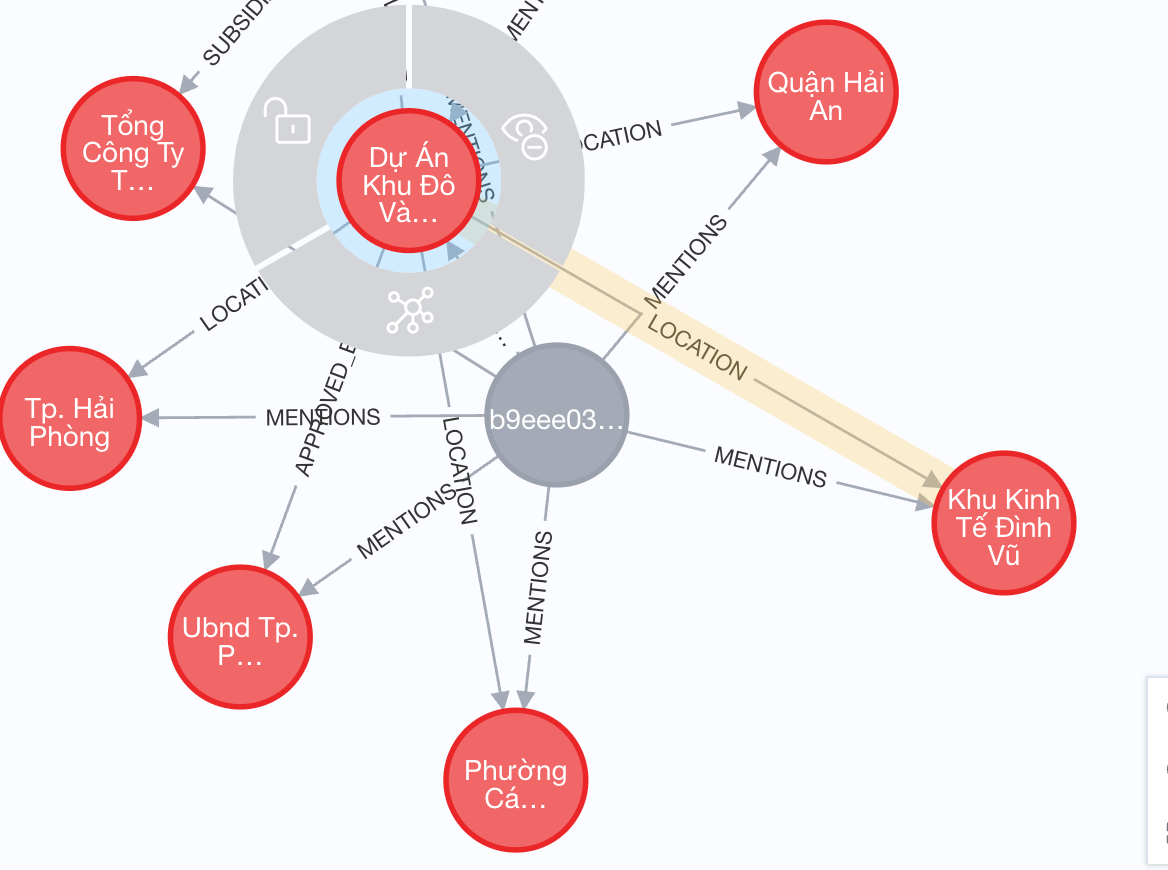

In [72]:
graph_chain.invoke({"query": "Dự Án Khu Đô Thị Và Dịch Vụ Tràng Cát LOCATION ở đâu ?"})



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Project {id: "Dự Án Khu Đô Thị Và Dịch Vụ Tràng Cát"})-[:LOCATION]->(l:Location)
RETURN l.id

Full Context:
[{'l.id': 'Hải Phòng'}, {'l.id': 'Quận Hải An'}, {'l.id': 'Khu Kinh Tế Đình Vũ - Cát Hải'}, {'l.id': 'Tp. Hải Phòng'}, {'l.id': 'Phường Tràng Cát'}]

> Finished chain.


{'query': 'Dự Án Khu Đô Thị Và Dịch Vụ Tràng Cát LOCATION ở đâu ?',
 'result': 'Dự Án Khu Đô Thị Và Dịch Vụ Tràng Cát LOCATION ở Phường Tràng Cát.'}